In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# !conda install -c conda-forge lightgbm
from lightgbm import LGBMRegressor


# 4. Метирки качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [27]:
import warnings

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [2]:
train = pd.read_csv('Kurs_project_task/train.csv')

In [3]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [7]:
import missingno as msno

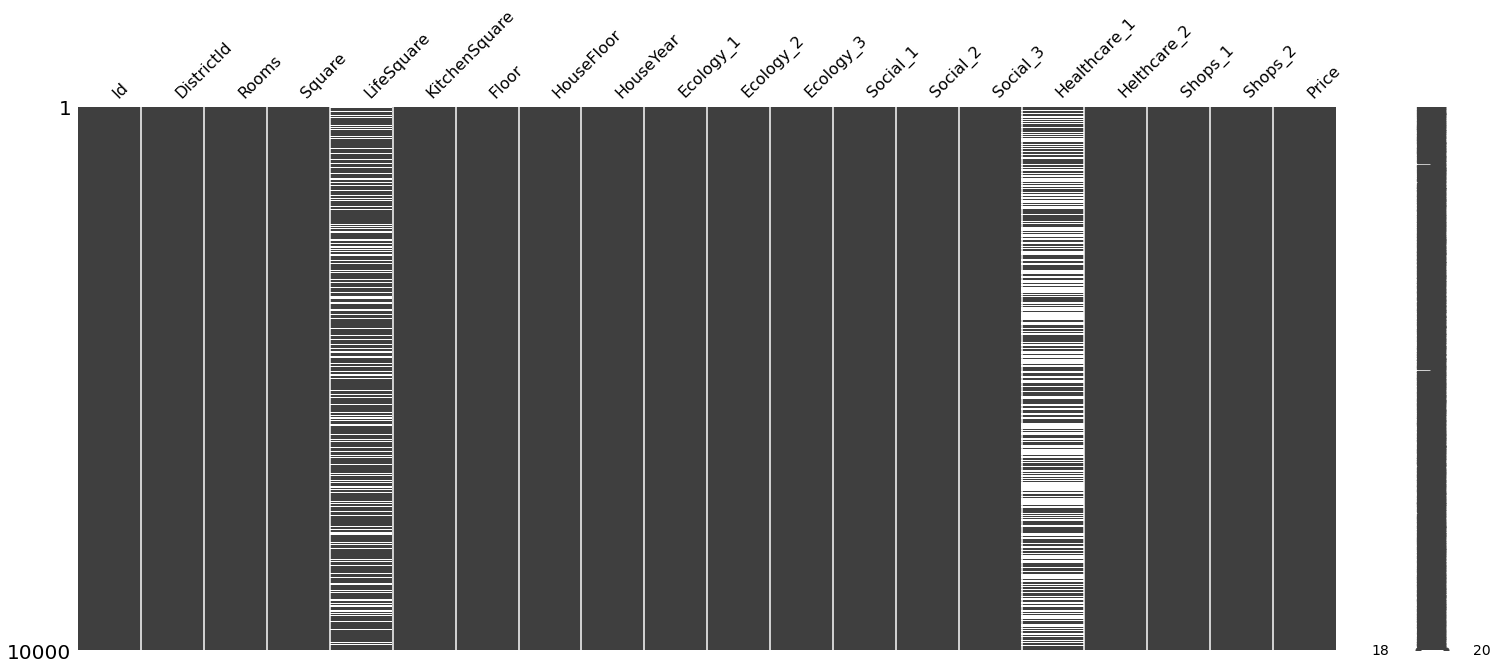

In [9]:
msno.matrix(train.sample(train.shape[0]));

In [11]:
total = train.isnull().sum().sort_values(ascending=False)
percentage = (train.isnull().sum()*100/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Persent'])
missing_data.head()

,Total,Persent
Healthcare_1,4798,47.98
LifeSquare,2113,21.13
Price,0,0.00
HouseYear,0,0.00
DistrictId,0,0.00


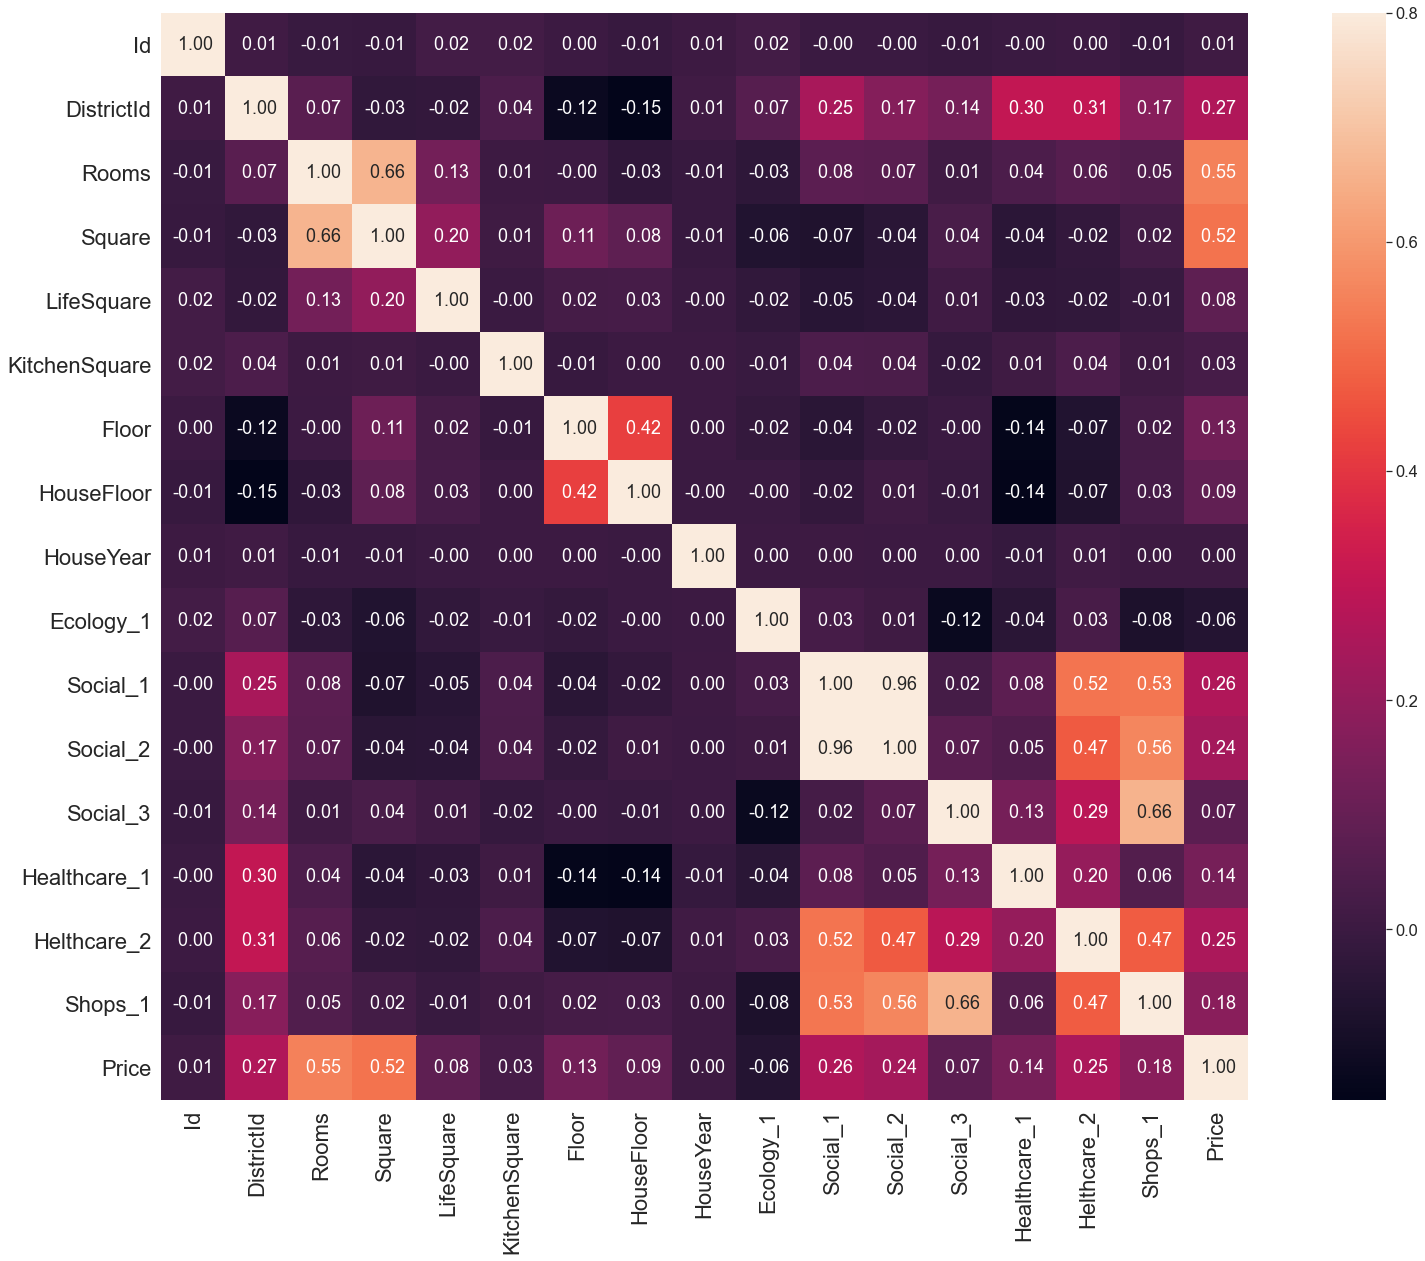

In [18]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(30, 20))
sns.set(font_scale=1.5)
sns.heatmap(corrmat, vmax=.8, annot=True, fmt=' .2f', square=True);

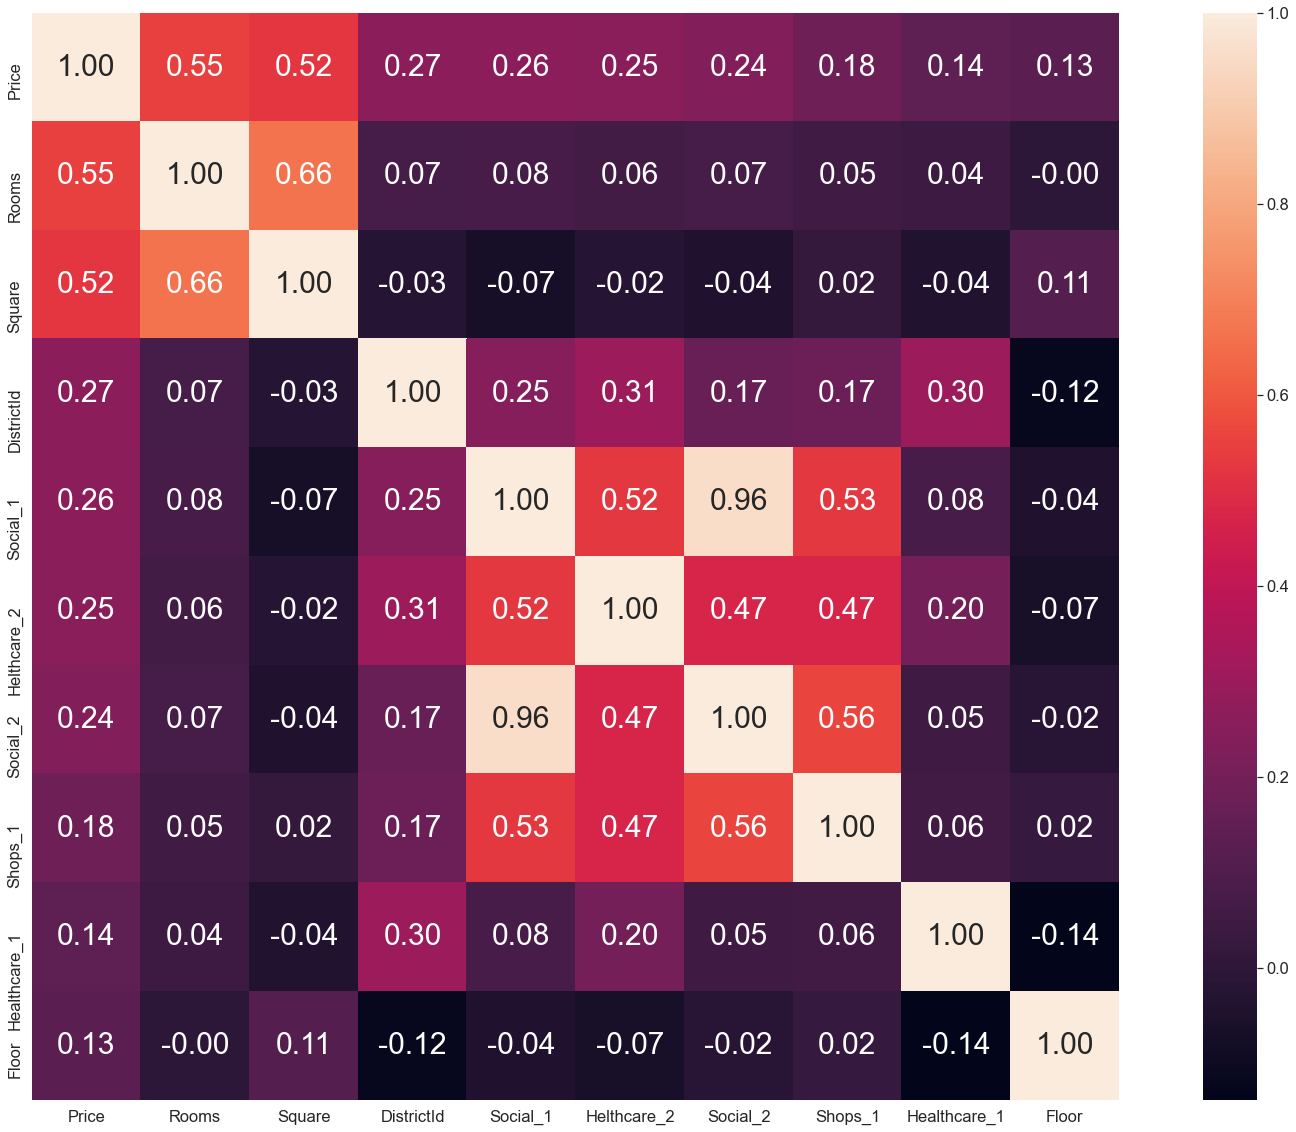

In [24]:
k = 10
cols = corrmat.nlargest(k, 'Price')['Price'].index
f, ax = plt.subplots(figsize=(30, 20))
sns.set(font_scale=1.5)
hm = sns.heatmap(train[cols].corr(), annot=True, square=True, fmt='.2f', annot_kws={'size': 30}, yticklabels=cols.values, xticklabels=cols.values);

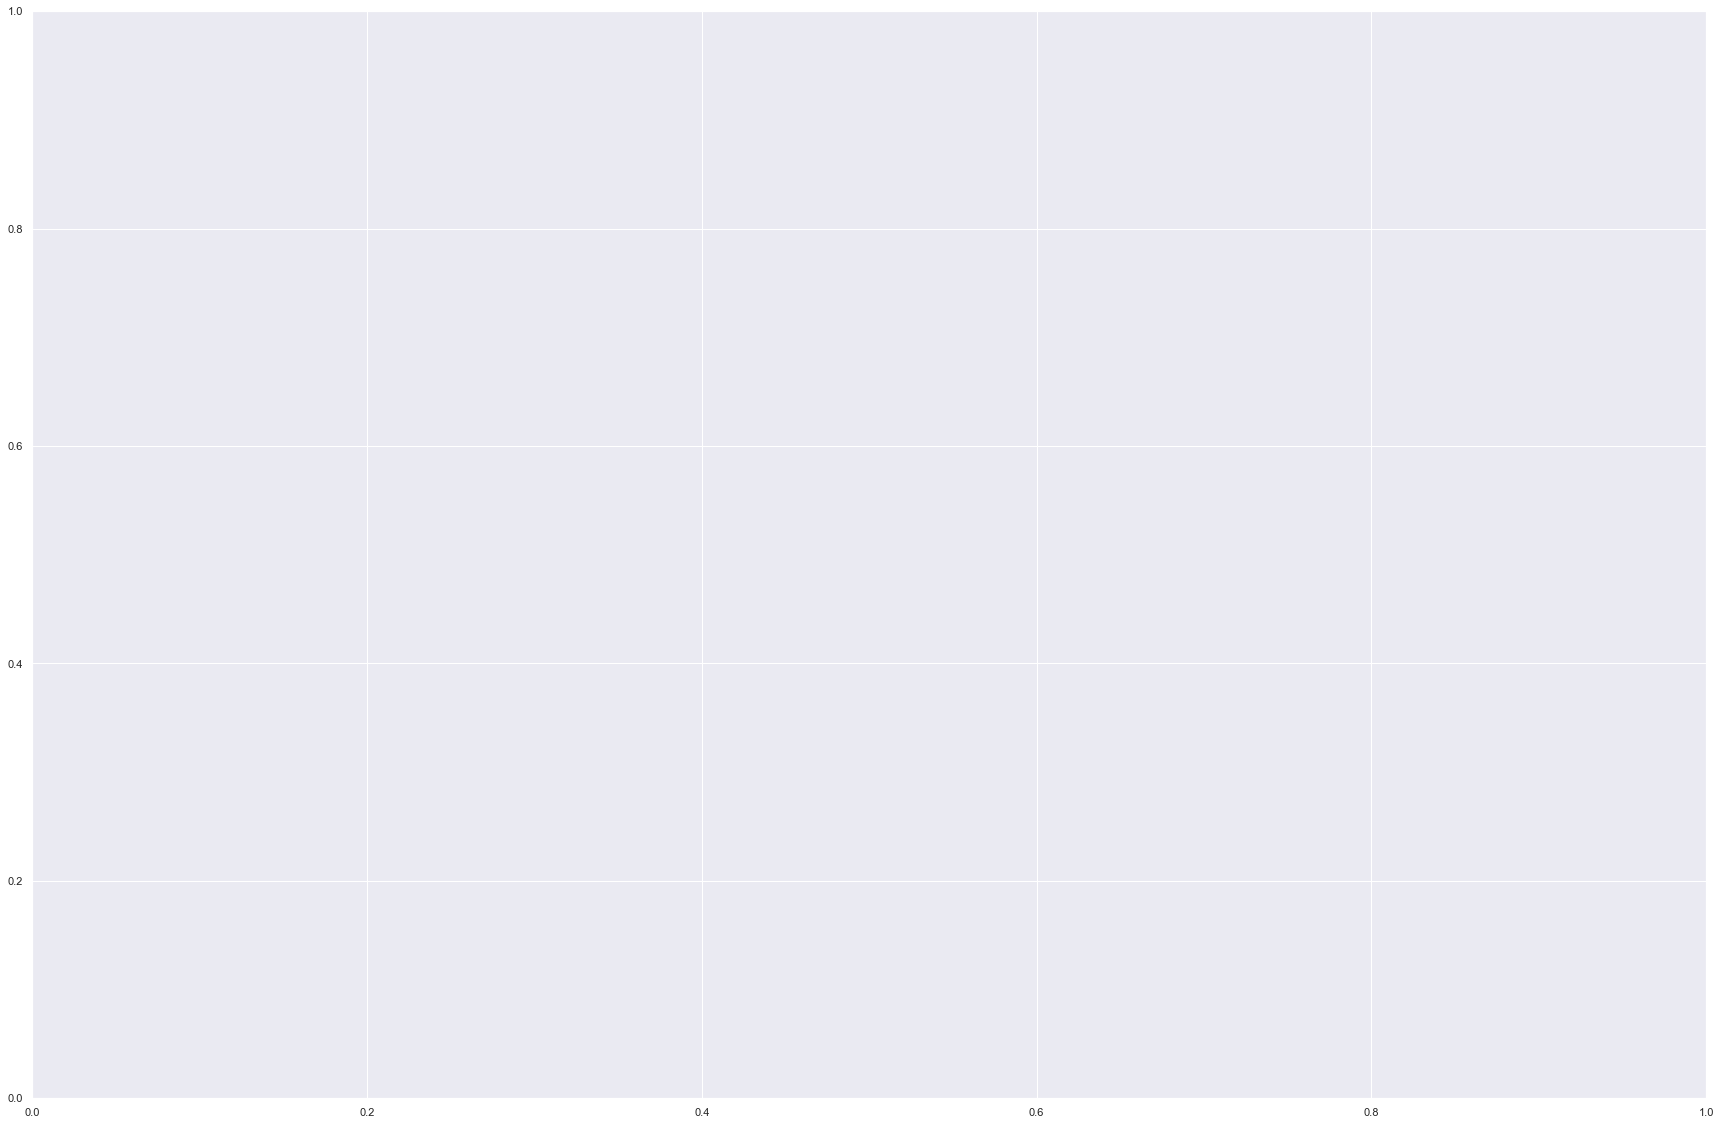

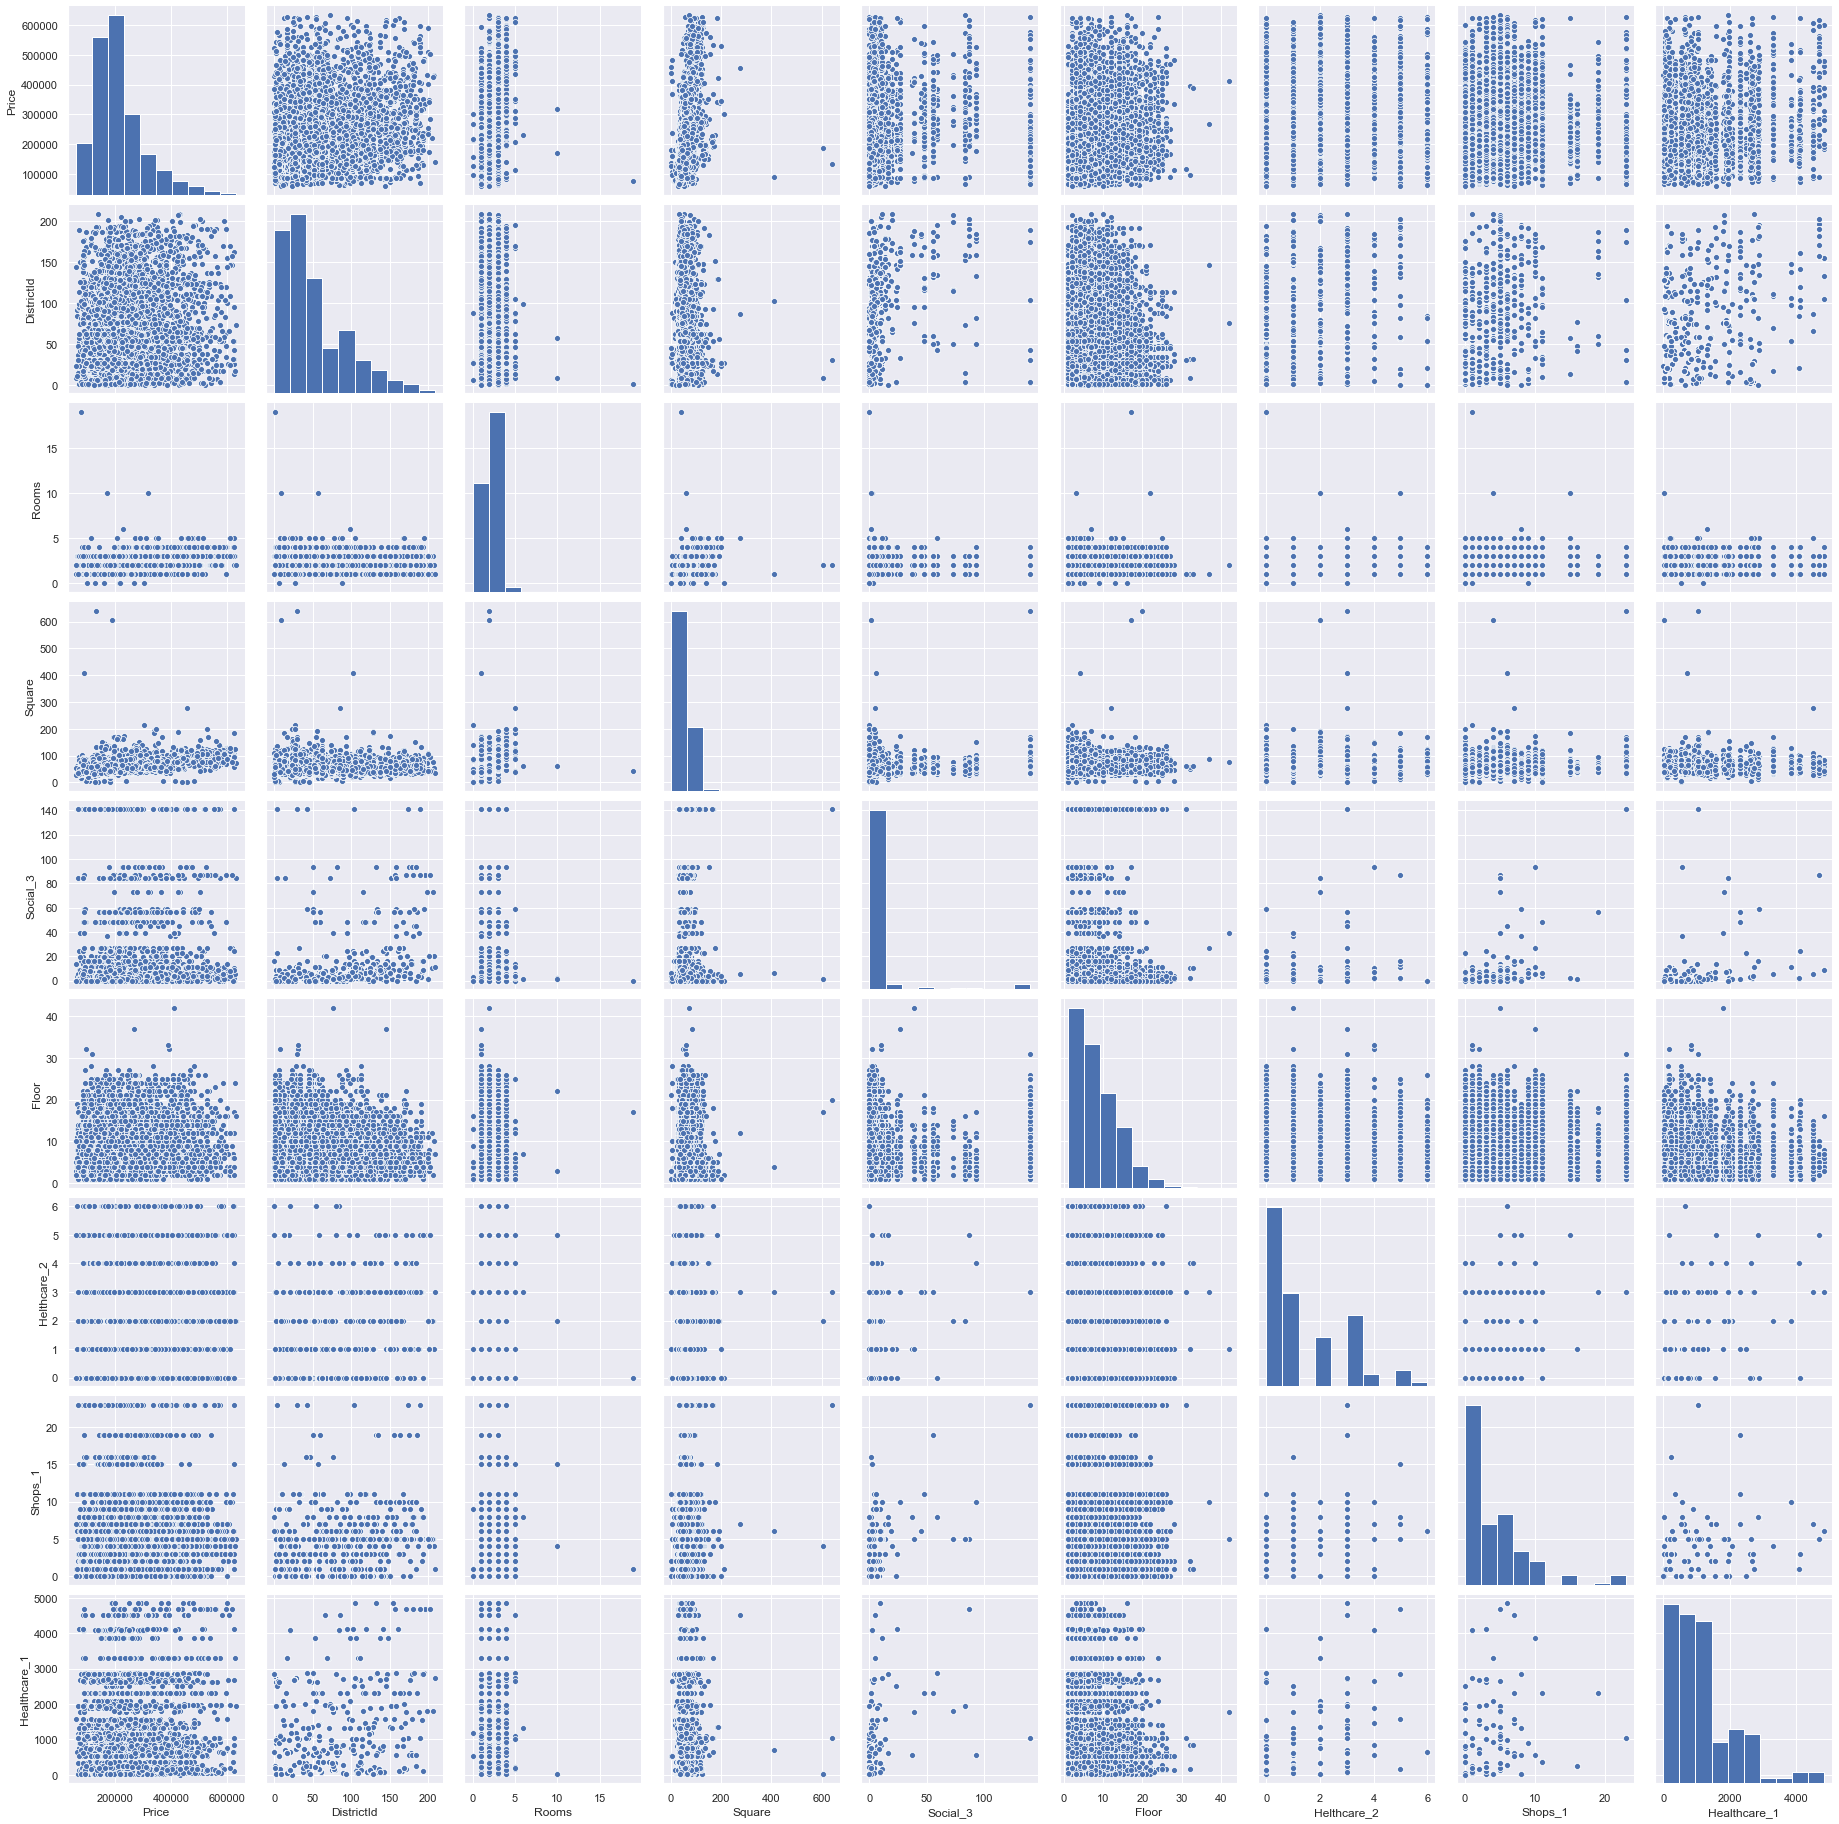

In [28]:
f, ax = plt.subplots(figsize=(30, 20))
sns.set()
cols = ['Price','DistrictId', 'Rooms', 'Square', 'Social_3', 'Floor', 'Helthcare_2', 'Shops_1', 'Healthcare_1']
sns.pairplot(train[cols], size = 2.8)
plt.show()

In [49]:
train = pd.read_csv('Kurs_project_task/train.csv')
X = train.drop('Price', axis=1)
y = train[['Price']]

In [50]:
X = X = pd.get_dummies(X)

In [51]:
X.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,NaN,0,11,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,0,229.0,1,3,0,1,0,1,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,0,1,0,1,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,0,1,0,1,0,1


In [52]:
train = pd.read_csv('Kurs_project_task/train.csv')
X = train.drop('Price', axis=1)
y = train[['Price']]

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.   
        https://www.kaggle.com/gemartin/load-data-reduce-memory-usage 
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    
    for col in df.columns:
        col_type = df[col].dtype        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))    
    return df

def feature_engineering(X):
    X = X.drop(['Id'],  axis=1)
    X['Healthcare_1'].fillna(X['Healthcare_1'].mean(), inplace=True)
    X['LifeSquare'].fillna(X['LifeSquare'].mean(), inplace=True)
    X = reduce_mem_usage(X)
    print('Shape:', X.shape)
    return X

# Model
X = feature_engineering(X)

Memory usage of dataframe is 1.37 MB
Memory usage after optimization is: 0.30 MB
Decreased by 78.4%
Shape: (10000, 18)


In [53]:
def metrics_regression(true, predicted):  
    """Metrics"""
    r2_square = metrics.r2_score(true, predicted) 
    print(f'R2_predicted:     {r2_square:.3f}')
    

def feature_importances(x, model):
    df = pd.DataFrame(sorted(list(zip(x, model.feature_importances_)), 
                      key=lambda x: x[1]))
    plt.figure(figsize=(12, 7))
    plt.barh(df[0], df[1])
    plt.show()
    
def model_RandomForestRegressor(X, y):
    model = RandomForestRegressor(max_depth=17,
                          min_samples_leaf=10,
                          n_estimators=98, 
                          random_state=100,
                          n_jobs=-1,
                          max_features=4)
    model.fit(X, y)
    cv_score = cross_val_score(model, X, y, 
                               scoring='r2', 
                               cv=KFold(n_splits=5, shuffle=True, random_state=100))
    # cv_score
    mean = cv_score.mean()
    std = cv_score.std()
    print()
    print('CV_score R2 mean: {:.3f} +- {:.3f}'.format(mean, std))    
    predictions = model.predict(X)
    metrics_regression(y, predictions)
    feature_importances(X, model)
    return model

In [55]:
model = model_RandomForestRegressor(X,y)

ValueError: could not convert string to float: 'B'

In [39]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [40]:
from sklearn import metrics

In [44]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=17, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=98, n_jobs=-1, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)>